# Modelo econométrico  para previsão dos gastos da previdência social 
 Utilizando o método SARIMA e Holt Winters

## 1- Tratando os dados

In [ ]:
# Importando as principais bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.dates as mdates
from statsmodels.tsa.stattools import adfuller
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_arch
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_arch


In [ ]:
# Criando o DF
df= pd.read_csv('dados_entrada/valor_despesa_inss.csv', sep=';', encoding='latin1',header=1)

# Drop total
df.drop('Total',axis=1,inplace=True)

In [5]:
# Substituir vírgulas por pontos para converter strings para floats
df.iloc[:, 1:] = df.iloc[:, 1:].replace(',', '.', regex=True).astype(float)

# Transformar o DataFrame no formato longo (melt)
df_long = df.melt(id_vars=['Ano'], var_name='Mês', value_name='Valor')

# Mapeamento dos meses para formato numérico
month_mapping = {
    'Janeiro': '01',
    'Fevereiro': '02',
    'Março': '03',
    'Abril': '04',
    'Maio': '05',
    'Junho': '06',
    'Julho': '07',
    'Agosto': '08',
    'Setembro': '09',
    'Outubro': '10',
    'Novembro': '11',
    'Dezembro': '12'
}

# Mapear os meses e remover linhas inválidas
df_long['Mês'] = df_long['Mês'].map(month_mapping)
df_long = df_long[df_long['Mês'].notna()]

# Criar a coluna 'Data' no formato MM/YYYY
df_long['Data'] = pd.to_datetime(df_long['Ano'].astype(str) + '/' + df_long['Mês'], format='%Y/%m', errors='coerce')

# Remover linhas inválidas onde 'Data' é NaT
df_long = df_long[df_long['Data'].notna()]

# Selecionar as colunas finais
df_final = df_long[['Data', 'Valor']]

In [6]:
# Organizar o DataFrame pela coluna 'Data' em ordem crescente
df_final = df_final.sort_values(by='Data')

# Resetar os índices para manter o DataFrame limpo (opcional)
df_final = df_final.reset_index(drop=True)

In [7]:
df = df_final

# Data vira index
df.set_index('Data', inplace=True)
# Somente valor depois de data 1999-12-01
df = df[df.index >= '2000-01-01']

# Converter a coluna 'Valor' para float
df['Valor'] = df['Valor'].astype(float)

# Arredondar para milhao e duas casas decimais
df['Valor'] = df['Valor'] / 1000000
df['Valor'] = df['Valor'].round(2)

df3 = df.copy()
df5 = df.copy()
df6 = df.copy()
df_sarima = df.copy()
df_fb = df.copy()

/var/folders/wk/k6089y_d7hv_rwb2m8vbm9cr0000gn/T/ipykernel_6189/711311016.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Valor'] = df['Valor'].astype(float)
/var/folders/wk/k6089y_d7hv_rwb2m8vbm9cr0000gn/T/ipykernel_6189/711311016.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Valor'] = df['Valor'] / 1000000
/var/folders/wk/k6089y_d7hv_rwb2m8vbm9cr0000gn/T/ipykernel_6189/711311016.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [8]:
df_sarima.to_excel('dados_saida/df_sarima.xlsx')

## 2- Análise de dados

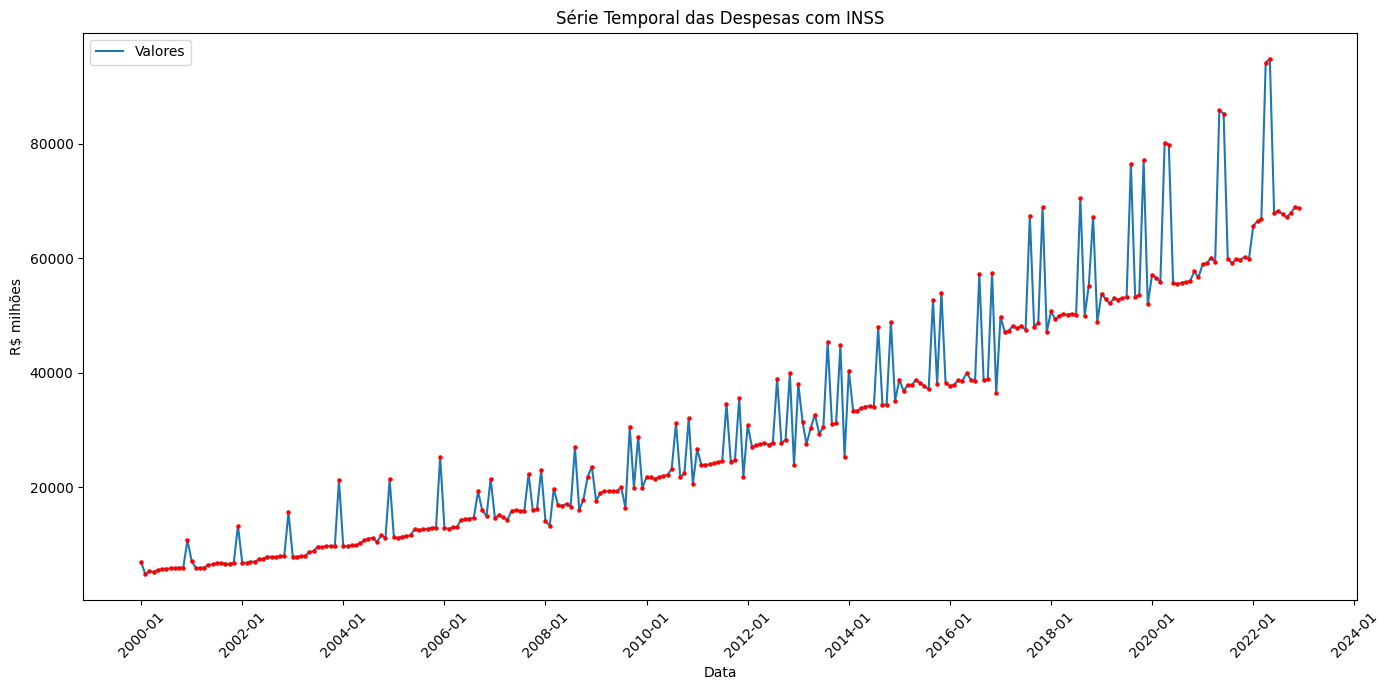

In [23]:
plt.figure(figsize=(14, 7))
sns.lineplot(x=df.index, y=df['Valor'], label='Valores')
plt.scatter(df.index, df['Valor'], color='red', s=5, zorder=5)

# Configurando o formato e os ticks do eixo X
plt.gca().xaxis.set_major_locator(mdates.YearLocator(2))  # Intervalo de 2 anos
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xticks(rotation=45)

# Configurações adicionais
plt.title('Série Temporal das Despesas com INSS')
plt.xlabel('Data')
plt.ylabel('R$ milhões')
plt.tight_layout()
plt.grid(False)
plt.show()


In [ ]:
# Criar o gráfico de série temporal interativo
fig = px.line(
    df_final,
    x=df_final.index,
    y='Valor',
    title='Série Temporal dos Gastos com INSS',
    labels={'x': 'Data', 'Valor': 'R$ milhões'},
)

# Ajustar layout para melhor visualização
fig.update_layout(
    xaxis_title='Data',
    yaxis_title='R$ milhões',
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=True),
    template='plotly_white'
)

# Exibir o gráfico interativo
fig.show()

/var/folders/wk/k6089y_d7hv_rwb2m8vbm9cr0000gn/T/ipykernel_6189/226759697.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



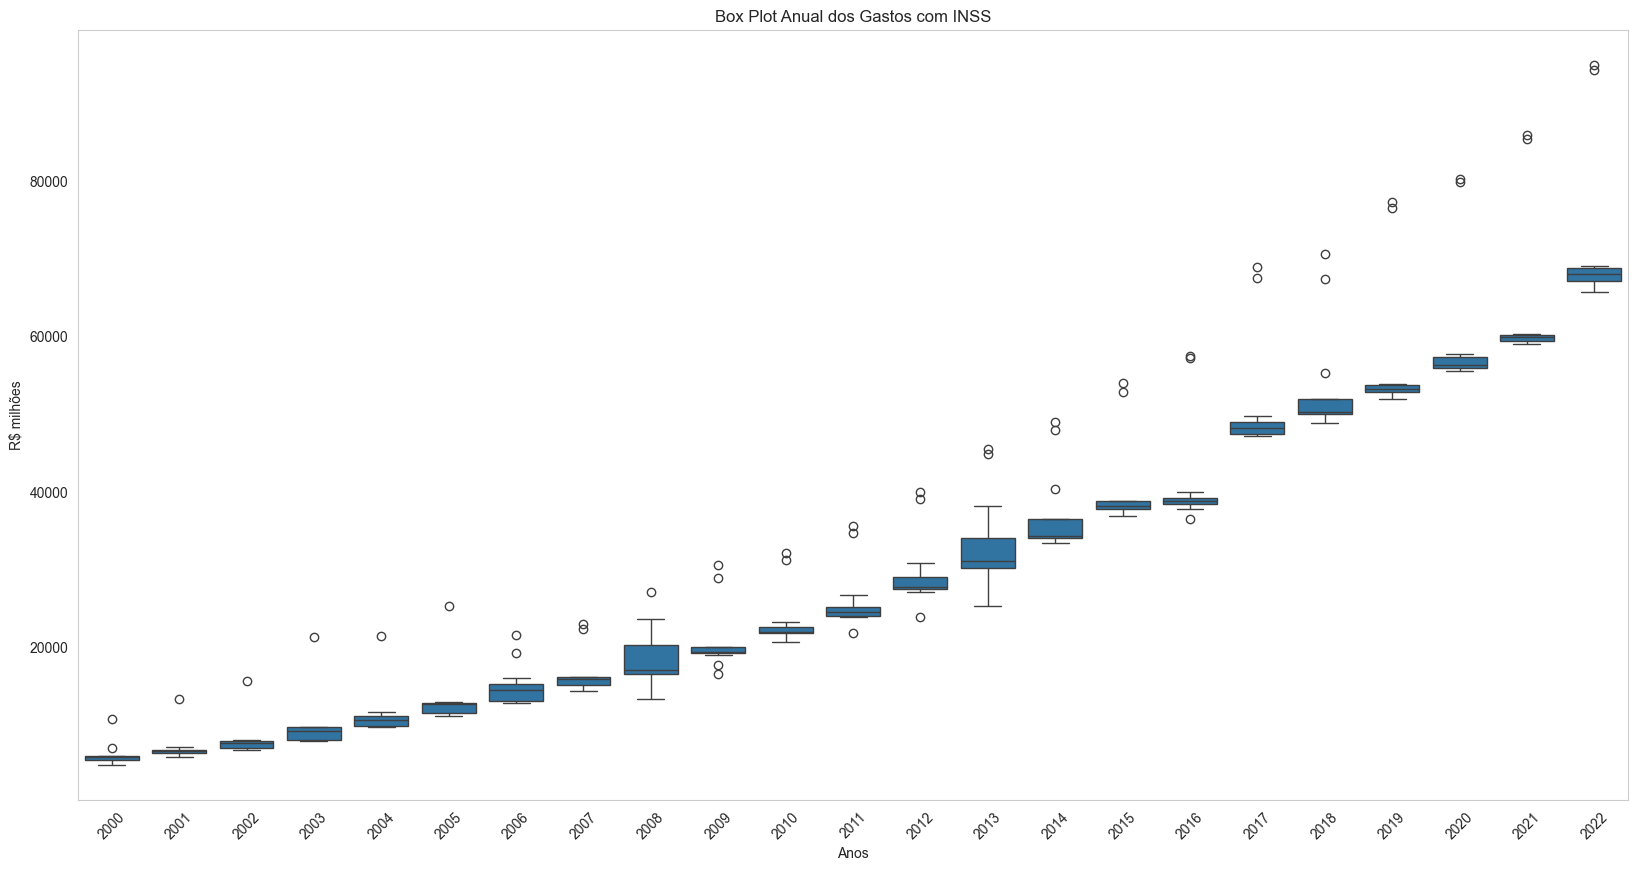

In [31]:
# Criando gráfico Box Plot anual
df['Ano'] = df.index.year


plt.figure(figsize=(20, 10))
sns.boxplot(x='Ano', y='Valor', data=df)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.title('Box Plot Anual dos Gastos com INSS')
plt.xlabel('Anos')
plt.ylabel('R$ milhões')
plt.grid(False)
plt.xticks(rotation=45)
plt.show()

/var/folders/wk/k6089y_d7hv_rwb2m8vbm9cr0000gn/T/ipykernel_6189/2681105952.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



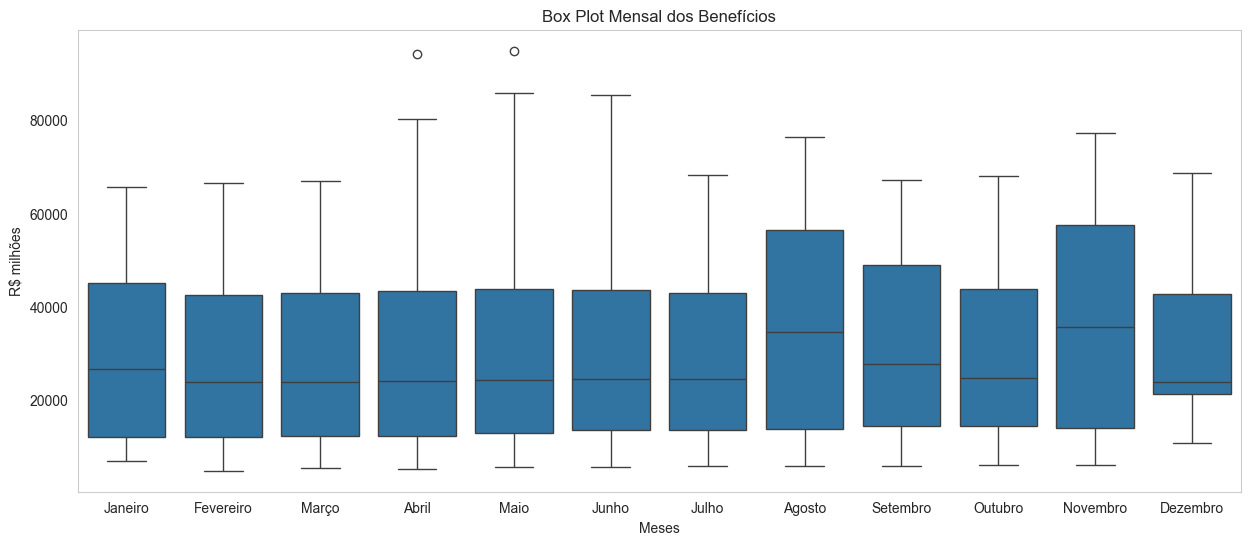

In [32]:
# Analisando efeito sazonal por meio do Box Plot
meses = {1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril', 5: 'Maio', 6: 'Junho',
         7: 'Julho', 8: 'Agosto', 9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'}

df['Mês'] = df.index.month.map(meses)


plt.figure(figsize=(15, 6))
sns.boxplot(x='Mês', y='Valor', data=df)
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.title('Box Plot Mensal dos Benefícios')
plt.xlabel('Meses')
plt.ylabel('R$ milhões')
plt.grid(False)
plt.show()

In [33]:
# Decompondo a série para novas análises
serie_temporal = df['Valor']
decomposicao = sm.tsa.seasonal_decompose(serie_temporal, model='additive')

<Figure size 2000x1000 with 0 Axes>

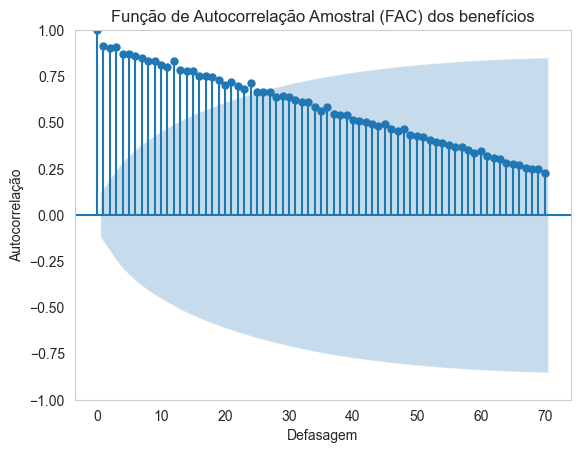

In [34]:
# Criando gráfico de FAC
plt.figure(figsize=(20, 10))
plot_acf(serie_temporal, lags=70)
plt.title('Função de Autocorrelação Amostral (FAC) dos benefícios')
plt.xlabel('Defasagem')
plt.ylabel('Autocorrelação')
plt.grid(False)
plt.show()

<Figure size 2000x1000 with 0 Axes>

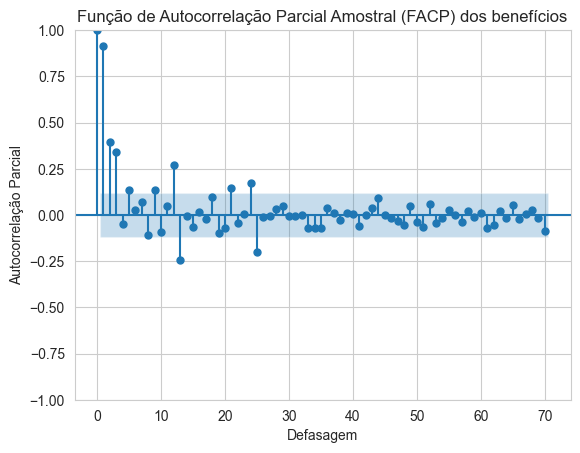

In [35]:
# Criando gráfico FACP
plt.figure(figsize=(20, 10))
plot_pacf(serie_temporal, lags=70)  
plt.title('Função de Autocorrelação Parcial Amostral (FACP) dos benefícios')
plt.xlabel('Defasagem')
plt.ylabel('Autocorrelação Parcial')
plt.show()

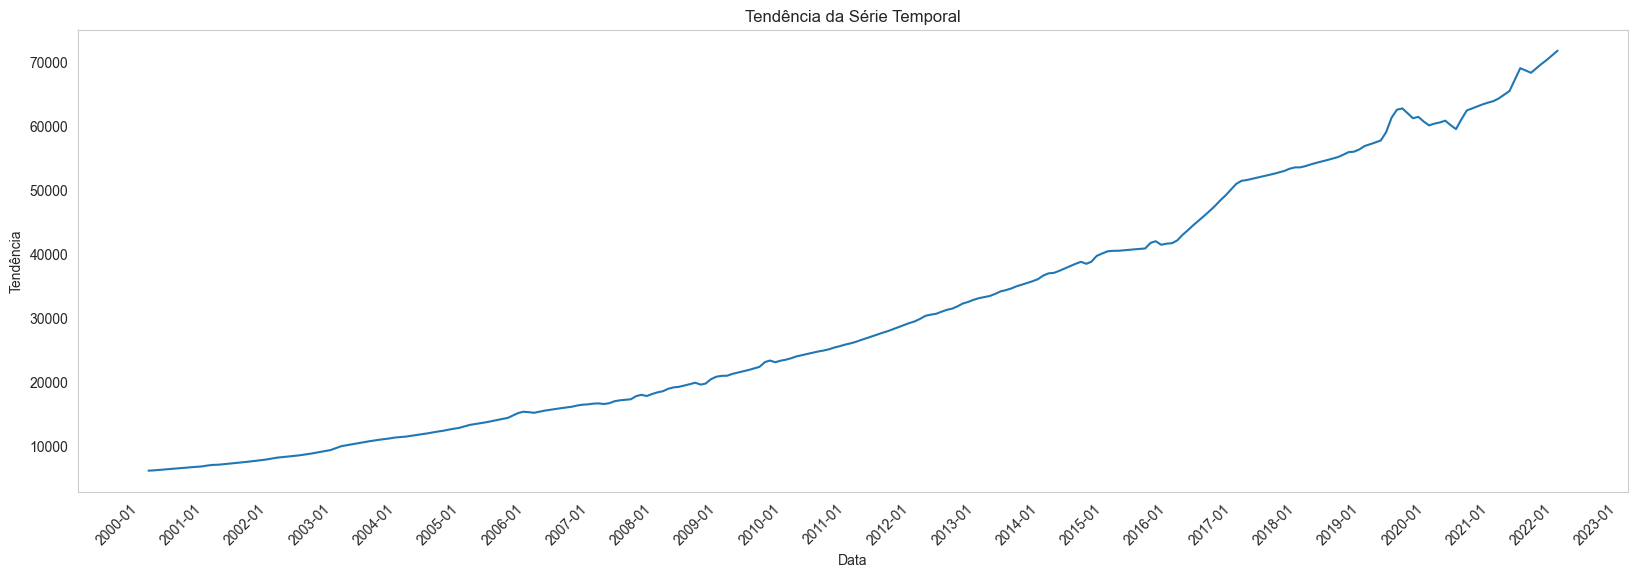

In [36]:
# Gráfico de tendência
plt.figure(figsize=(20, 6))
sns.lineplot(data=decomposicao.trend)
plt.title('Tendência da Série Temporal')
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xlabel('Data')
plt.ylabel('Tendência')
plt.grid(False)
plt.xticks(rotation=45)
plt.show()

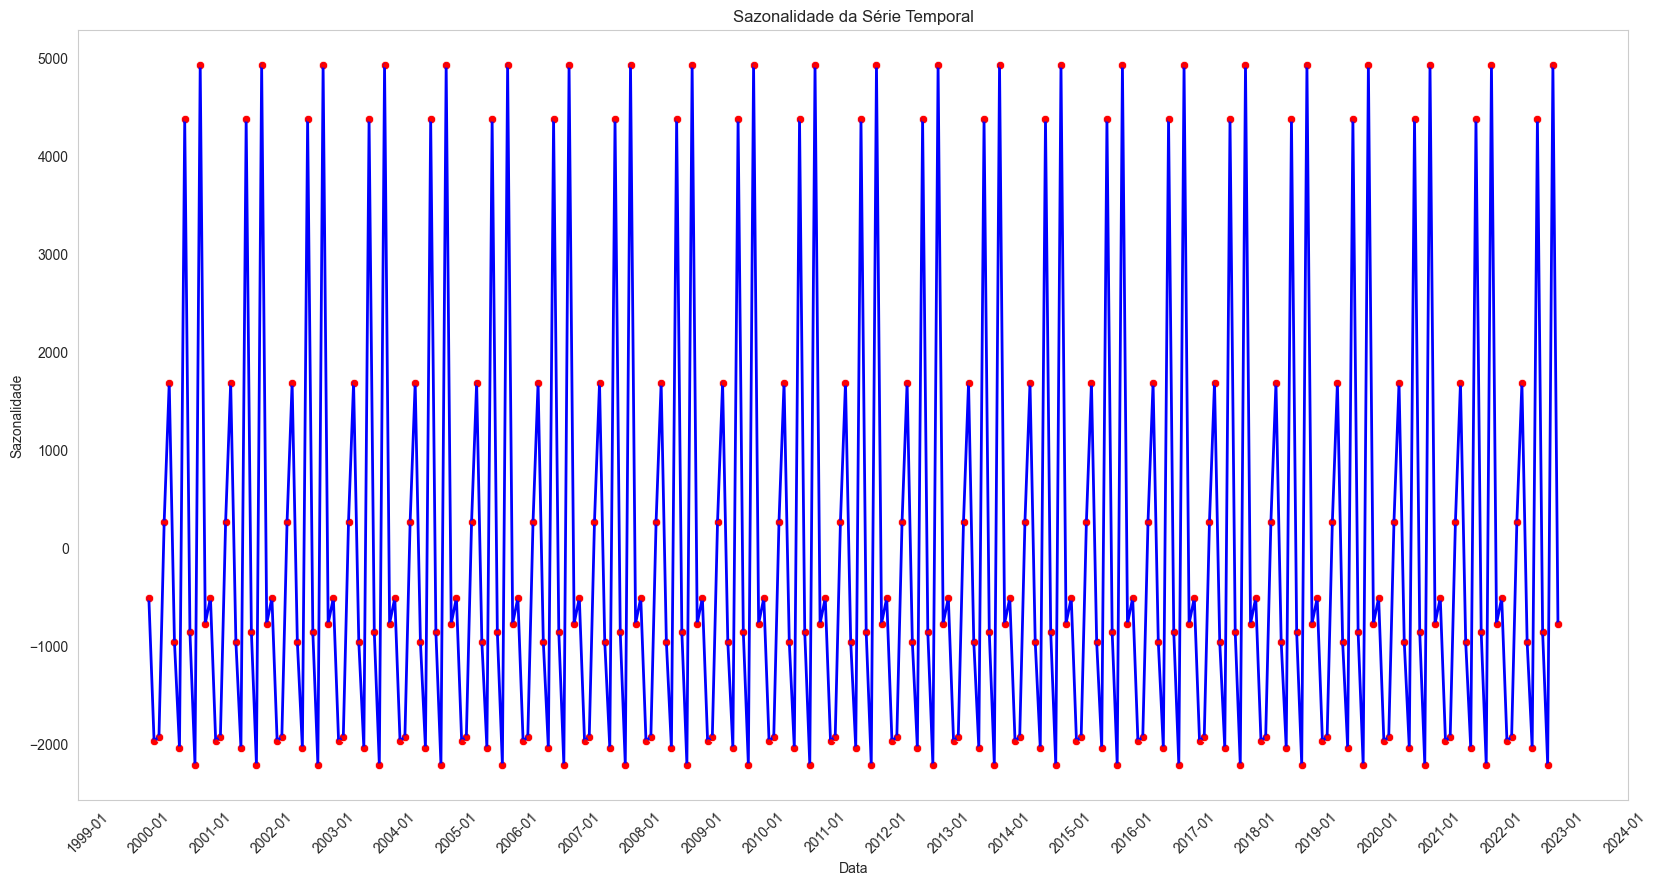

In [37]:
# Gráfico de Sazonalidade
plt.figure(figsize=(20, 10))
sns.lineplot(data=decomposicao.seasonal, color='blue', linewidth=2)
sns.scatterplot(data=decomposicao.seasonal, color='red', marker='o')
plt.scatter(decomposicao.seasonal.index, decomposicao.seasonal.values, color='red', s=5, zorder=5)
plt.title('Sazonalidade da Série Temporal')
plt.gca().xaxis.set_major_locator(mdates.YearLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xlabel('Data')
plt.grid(False)
plt.ylabel('Sazonalidade')
plt.xticks(rotation=45)
plt.show()

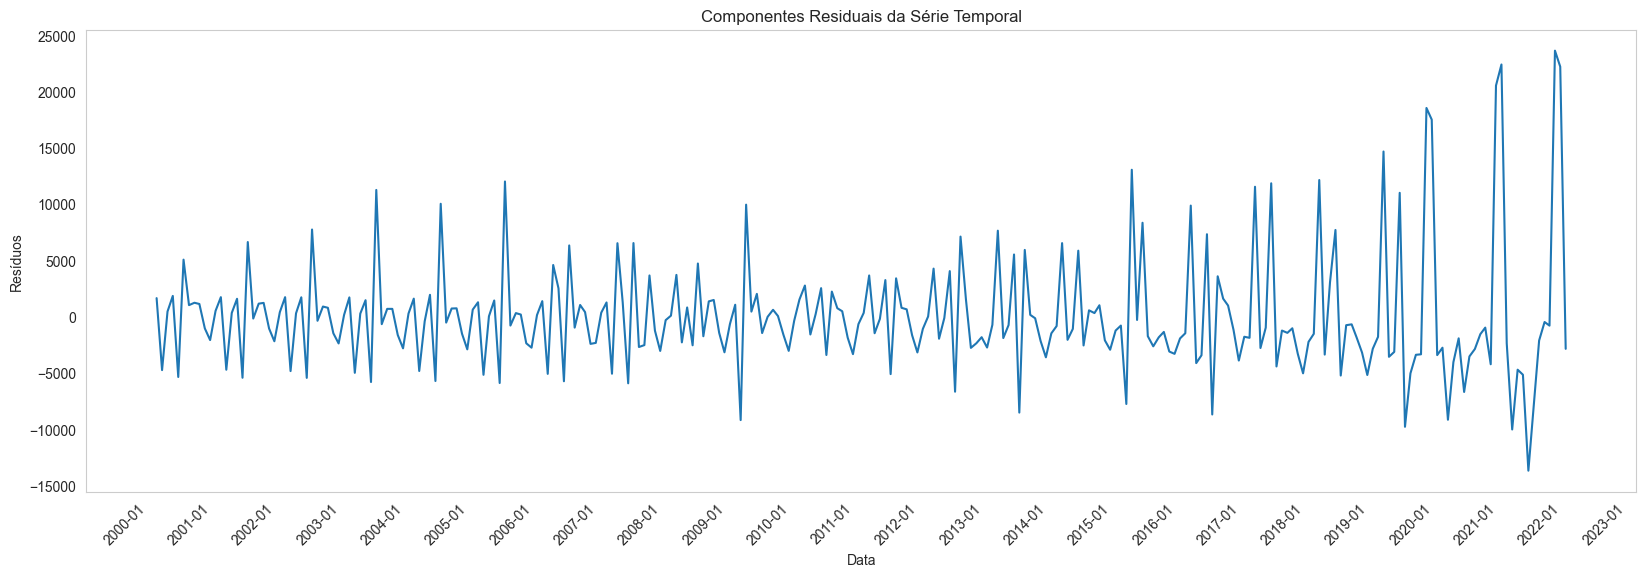

In [38]:
# Gráfico de ruído
plt.figure(figsize=(20,6))
sns.lineplot(data=decomposicao.resid)
plt.title('Componentes Residuais da Série Temporal')
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xlabel('Data')
plt.grid(False)
plt.ylabel('Resíduos')
plt.xticks(rotation=45)
plt.show()


In [39]:
# Realizando teste de hipótese de estacionalidade
result= adfuller(df3)
print(f'P-valor {result[1]}')

P-valor 1.0


In [40]:
# Realizando uma diferenciação na série para corrigir a estacionalidade
df3= df3.diff()
df3=df3.dropna()
result2= adfuller(df3)
print(f'P-valor {result2[1]}')

P-valor 9.22710845293677e-27


<Figure size 2000x600 with 0 Axes>

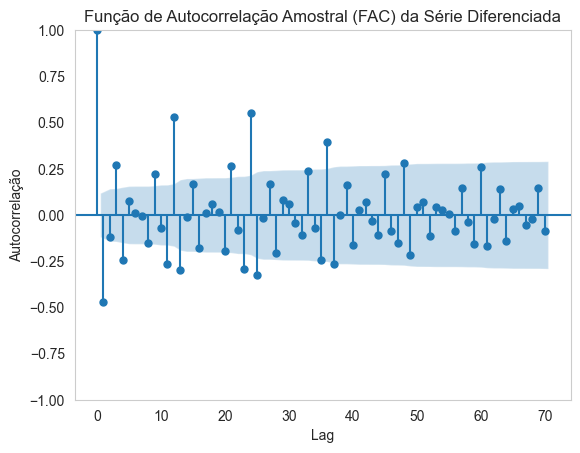

In [41]:
# Novo gráfico FAC
plt.figure(figsize=(20, 6))
plot_acf(df3, lags=70)
plt.title('Função de Autocorrelação Amostral (FAC) da Série Diferenciada')
plt.xlabel('Lag')
plt.ylabel('Autocorrelação')
plt.grid(False)
plt.show()

In [42]:
# Garantindo que a série está em formato correto
N = len(df3)  # Número de observações na série

# Cálculo da função de autocorrelação (FAC) até lag 11
fac_values = sm.tsa.acf(df3, nlags=11)

# Intervalo de confiança para significância estatística (95%)
z_score = 1.96  # Para 95% de confiança
threshold = z_score / np.sqrt(N)  # Margem de erro de 5%

# Criar uma lista apenas com os lags significativos
lags_significativos = [lag for lag, val in enumerate(fac_values) if abs(val) > threshold]

# Exibir a lista de lags significativos
print("Lags com dependência significativa:", lags_significativos)




Lags com dependência significativa: [0, 1, 2, 3, 4, 8, 9, 11]


In [43]:
# fac menor igual a 4
fac = lags_significativos 

<Figure size 2000x1000 with 0 Axes>

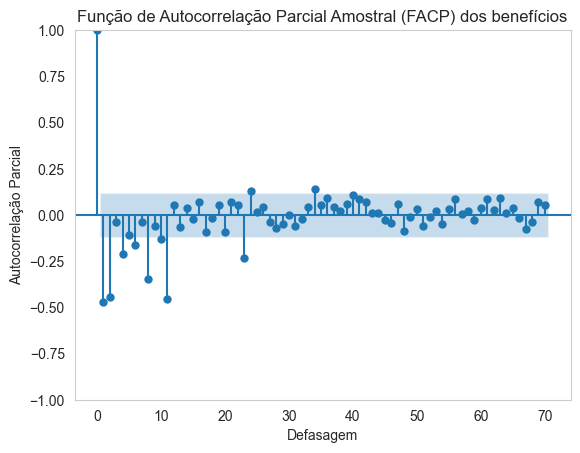

In [44]:
# Novo gráfico FACP
plt.figure(figsize=(20, 10))
plot_pacf(df3, lags=70)  # Define o número de lags para calcular a FACP
plt.title('Função de Autocorrelação Parcial Amostral (FACP) dos benefícios')
plt.xlabel('Defasagem')
plt.ylabel('Autocorrelação Parcial')
plt.grid(False)
plt.show()

In [45]:
# Garantindo que a série está em formato correto
N = len(df3)  # Número de observações na série

# Cálculo da função de autocorrelação parcial (FACP) até lag 11
facp_values = sm.tsa.pacf(df3, nlags=11)

# Intervalo de confiança para significância estatística (95%)
z_score = 1.96  # Para 95% de confiança
threshold = z_score / np.sqrt(N)  # Margem de erro de 5%

# Criar uma lista apenas com os lags significativos
lags_significativos_facp = [lag for lag, val in enumerate(facp_values) if abs(val) > threshold]

# Exibir a lista de lags significativos na FACP
print("Lags com dependência significativa na FACP:", lags_significativos_facp)

Lags com dependência significativa na FACP: [0, 1, 2, 4, 6, 8, 10, 11]


In [46]:
facp = lags_significativos_facp

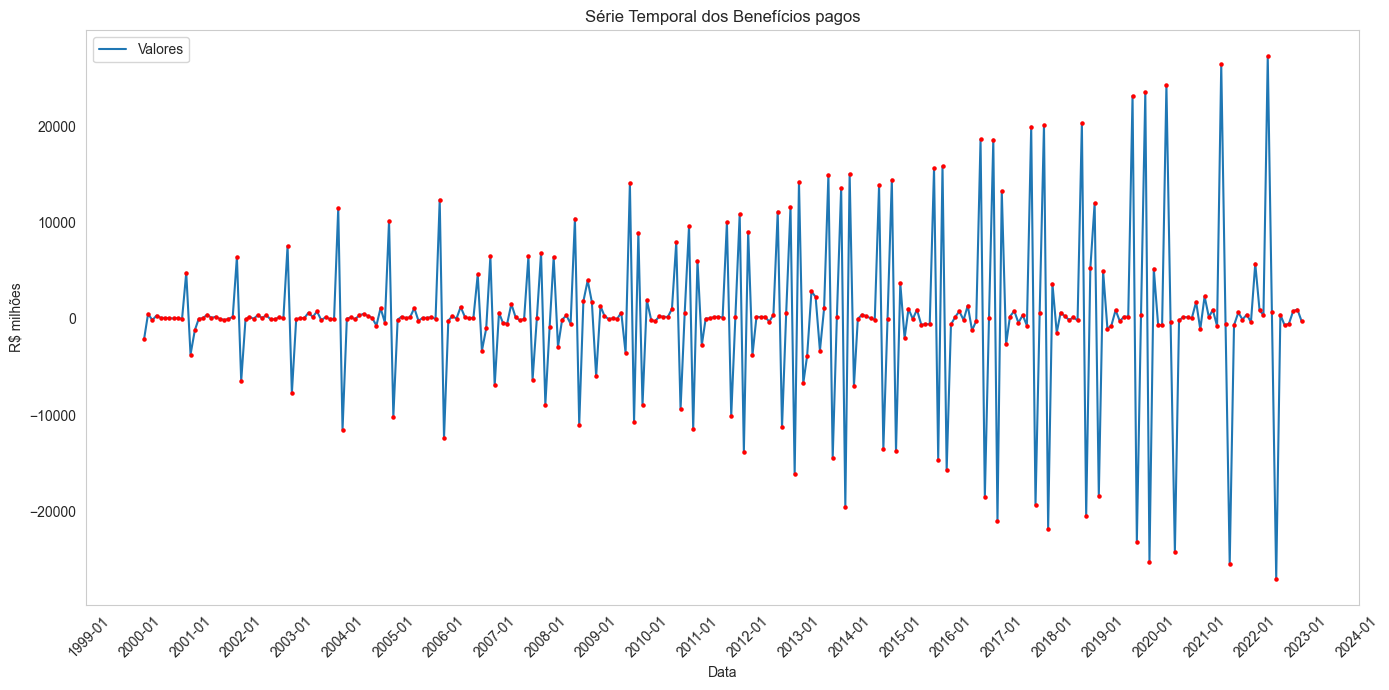

In [47]:
# Novo gráfico de série temporal
plt.figure(figsize=(14, 7))
sns.lineplot(x=df3.index, y=df3['Valor'], label='Valores')
plt.scatter(df3.index, df3['Valor'], color='red', s=5, zorder=5)
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.YearLocator())
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xticks(rotation=45)


plt.title('Série Temporal dos Benefícios pagos')
plt.xlabel('Data')
plt.ylabel('R$ milhões')

# Mostrar o gráfico
plt.tight_layout()
plt.grid(False)
plt.show()


In [48]:
s = 12  
N = len(df3)  # Número de observações na série

# Diferenciar sazonalmente a série (para remover efeitos sazonais)
df3_s_diff = df3.diff(s).dropna()

# Calcular FAC e FACP até 3 ciclos sazonais (36 lags)
fac_values = sm.tsa.acf(df3_s_diff, nlags=s*3)
facp_values = sm.tsa.pacf(df3_s_diff, nlags=s*3)

# Intervalo de confiança para significância estatística (95%)
z_score = 1.96  
threshold = z_score / np.sqrt(N)  

# Criar listas com os lags significativos
lags_significativos_fac = [lag for lag, val in enumerate(fac_values) if abs(val) > threshold]
lags_significativos_facp = [lag for lag, val in enumerate(facp_values) if abs(val) > threshold]

# Exibir os resultados
print("Lags significativos na FAC (Q):", lags_significativos_fac)
print("Lags significativos na FACP (P):", lags_significativos_facp)

Lags significativos na FAC (Q): [0, 1, 2, 3, 4, 5, 7, 8, 11, 12, 13, 17, 20, 24, 25]
Lags significativos na FACP (P): [0, 1, 2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]


In [49]:
# fac ate  5
fac_s = lags_significativos_fac 

# facp ate 4
facp_s = lags_significativos_facp 

## 3- MODELO SARIMA

In [50]:
# Importando bibliotecas para estimar os erros
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error

In [51]:
# Criando uma função para um parâmetro de erro
def mean_percentage_error(Y,y):
    mpe = np.mean((Y - y )/ Y) * 100
    return mpe

In [52]:
# Função para criar DF com valores dos erros
def teste_erro(serie,previsao):

    MAD = mean_absolute_error(y_true=serie,y_pred=previsao)
    MAPE = mean_absolute_percentage_error(y_true=serie,y_pred=previsao)
    MSD = mean_squared_error(y_true=serie,y_pred=previsao)
    MPE = mean_percentage_error(serie,previsao)

    erros = pd.DataFrame({
        'Metric': ['MAD', 'MAPE', 'MSD', 'MPE'],
        'Value': [MAD, MAPE, MSD, MPE]
    })
    
    return erros

In [53]:
from itertools import product
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings


In [54]:
# print fac e facp 
print(fac)
print(facp)
print(fac_s)
print(facp_s)

[0, 1, 2, 3, 4, 8, 9, 11]
[0, 1, 2, 4, 6, 8, 10, 11]
[0, 1, 2, 3, 4, 5, 7, 8, 11, 12, 13, 17, 20, 24, 25]
[0, 1, 2, 3, 4, 7, 8, 9, 11, 12, 13, 14, 20, 21, 22, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36]


In [55]:
# quero valores acima de 8
fac = [x for x in fac if x >0 and x < 5]
facp = [x for x in facp if x > 0 and x < 7]
fac_s = [x for x in fac_s if x > 0 and x <7]
facp_s = [x for x in facp_s if x > 0 and x < 7]



In [56]:
"""  
import modelo_sarima  # Importa o módulo

# Definir intervalos personalizados
p_values = fac 
d_values = [1]  # Manter d fixo
q_values = facp  
P_values = fac_s  
D_values = [1] 
Q_values = facp_s 
s = 12  # Sazonalidade mensal

# Rodar a função com os intervalos escolhidos
modelo_sarima.run_sarima_grid_search(
    file_path="dados_saida/df_sarima.xlsx",
    output_file="resultado/resultados_sarima_teste.xlsx",
    p_values=p_values,
    d_values=d_values,
    q_values=q_values,
    P_values=P_values,
    D_values=D_values,
    Q_values=Q_values,
    s=s
)
 
"""

'  \nimport modelo_sarima  # Importa o módulo\n\n# Definir intervalos personalizados\np_values = fac \nd_values = [1]  # Manter d fixo\nq_values = facp  \nP_values = fac_s  \nD_values = [1] \nQ_values = facp_s \ns = 12  # Sazonalidade mensal\n\n# Rodar a função com os intervalos escolhidos\nmodelo_sarima.run_sarima_grid_search(\n    file_path="dados_saida/df_sarima.xlsx",\n    output_file="resultado/resultados_sarima_teste.xlsx",\n    p_values=p_values,\n    d_values=d_values,\n    q_values=q_values,\n    P_values=P_values,\n    D_values=D_values,\n    Q_values=Q_values,\n    s=s\n)\n \n'

In [60]:
result_df = pd.read_excel('resultado_sarima_consolidado.xlsx')

In [64]:
# Carregar o DataFrame fixo (suponha que df_sarima já esteja carregado no ambiente)
df_sarima.index = pd.to_datetime(df_sarima.index)  # Garantir que o índice seja datetime

def rodar_sarimax(df_params, index):
    """
    Roda o modelo SARIMAX com base nos parâmetros de uma linha específica do DataFrame `df_params`.

    Parâmetros:
    df_params (pd.DataFrame): DataFrame contendo os parâmetros dos modelos.
    index (int): Índice da linha no DataFrame para extrair os parâmetros.

    Retorna:
    Modelo ajustado SARIMAX.
    """
    row = df_params.iloc[index]
    
    # Extraindo os parâmetros da linha
    p, d, q = int(row["p"]), int(row["d"]), int(row["q"])
    P, D, Q = int(row["P"]), int(row["D"]), int(row["Q"])
    
    # Definir as ordens
    order = (p, d, q)
    seasonal_order = (P, D, Q, 12)  # Mantendo sazonalidade fixa em 12 meses
    
    # Ajustando o modelo SARIMAX sempre com df_sarima
    model = sm.tsa.statespace.SARIMAX(df_sarima["Valor"], 
                                      order=order, 
                                      seasonal_order=seasonal_order,
                                      enforce_stationarity=False, 
                                      enforce_invertibility=False)
    results = model.fit()
    
    return results



## 4- Resultados

In [65]:
result_df.head(10)

,p,d,q,P,D,Q,AIC,BIC,Log-Likelihood
0,9,1,10,4,1,7,62.000000,158.842883,0.000000
1,8,1,8,7,1,7,62.000000,159.209752,0.000000
2,8,1,10,7,1,7,66.000000,169.090811,0.000000
3,9,1,8,8,1,7,66.000000,167.065636,0.000000
4,9,1,11,7,1,7,70.000000,179.129783,0.000000
5,11,1,10,7,1,7,72.000000,184.462703,0.000000
6,9,1,10,5,1,7,152.268181,252.235028,-44.134090
7,8,1,10,8,1,7,169.795478,274.138221,-50.897739
8,9,1,11,8,1,7,266.264523,376.517944,-97.132262
9,11,1,11,4,1,11,2433.947816,2539.554509,-1178.973908


In [83]:
result_df.index.freq = 'MS' 
resultado_modelo = rodar_sarimax(result_df, 10)
resultado_modelo.summary()

/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning:

Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.

/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                                 Valor   No. Observations:                  276
Model:             SARIMAX(11, 1, 11)x(5, 1, 11, 12)   Log Likelihood               -1178.795
Date:                               Wed, 14 May 2025   AIC                           2435.590
Time:                                       19:43:15   BIC                           2543.976
Sample:                                   01-01-2000   HQIC                          2479.603
                                        - 12-01-2022                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5683      1.403     -0.405      0.685      -3.317       2.181
ar.L2         -1.4365      1.014     -1.416      0.157      -3.425       0.552
ar.L3         -0.7684      2.252     -0.341      0.733      -5.183       3.646
ar.L4         -1.6141      1.663     -0.971      0.332      -4.874       1.645
ar.L5         -0.7548      2.755     -0.274      0.784      -6.154       4.644
ar.L6         -1.0922      1.911     -0.572      0.568      -4.838       2.653
ar.L7         -0.3762      2.178     -0.173      0.863      -4.645       3.892
ar.L8         -0.4132      1.407     -0.294      0.769      -3.171       2.345
ar.L9          0.0387      1.191      0.033      0.974      -2.295       2.373
ar.L10         0.4129      0.596      0.692      0.489      -0.756       1.582
ar.L11         0.1038      0.490      0.212      0.832      -0.856       1.064
ma.L1          0.1440      1.529      0.094      0.925      -2.854       3.142
ma.L2          0.5279      0.621      0.850      0.395      -0.689       1.744
ma.L3          0.1726      0.972      0.178      0.859      -1.733       2.078
ma.L4          0.4047      0.617      0.656      0.512      -0.804       1.613
ma.L5         -0.0025      0.770     -0.003      0.997      -1.512       1.507
ma.L6         -0.3792      0.434     -0.874      0.382      -1.230       0.472
ma.L7         -0.2686      0.597     -0.450      0.653      -1.438       0.901
ma.L8         -0.4590      0.513     -0.895      0.371      -1.464       0.546
ma.L9         -0.2050      0.740     -0.277      0.782      -1.656       1.246
ma.L10        -0.7824      0.484     -1.616      0.106      -1.731       0.166
ma.L11         0.1420      1.215      0.117      0.907      -2.240       2.524
ar.S.L12      -0.0443      2.044     -0.022      0.983      -4.050       3.962
ar.S.L24      -0.0025      1.861     -0.001      0.999      -3.650       3.645
ar.S.L36      -0.0080      1.139     -0.007      0.994      -2.240       2.224
ar.S.L48      -0.0122      1.395     -0.009      0.993      -2.747       2.722
ar.S.L60       0.1311      0.904      0.145      0.885      -1.641       1.904
ma.S.L12      -0.2271      2.083     -0.109      0.913      -4.310       3.856
ma.S.L24      -0.0553      2.397     -0.023      0.982      -4.753       4.642
ma.S.L36      -0.3399      1.402     -0.242      0.808      -3.088       2.408
ma.S.L48      -0.1517      2.127     -0.071      0.943      -4.321       4.018
ma.S.L60      -0.0071      1.435     -0.005      0.996      -2.820       2.806
ma.S.L72       0.8043      0.285      2.819      0.005       0.245       1.363
ma.S.L84      -0.5537      1.657     -0.334      0.738      -3.802       2.694
ma.S.L96      -0.3238      2.510     -0.129      0.897      -5.243       4.596
ma.S.L108     -0.4482      1.152     -0.389      0.697      -2.706       1.810
ma.S.L120     -0.0580    

/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/Users/pietrapdornelos/.pyenv/versions/3.13.2/lib/python3.13/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



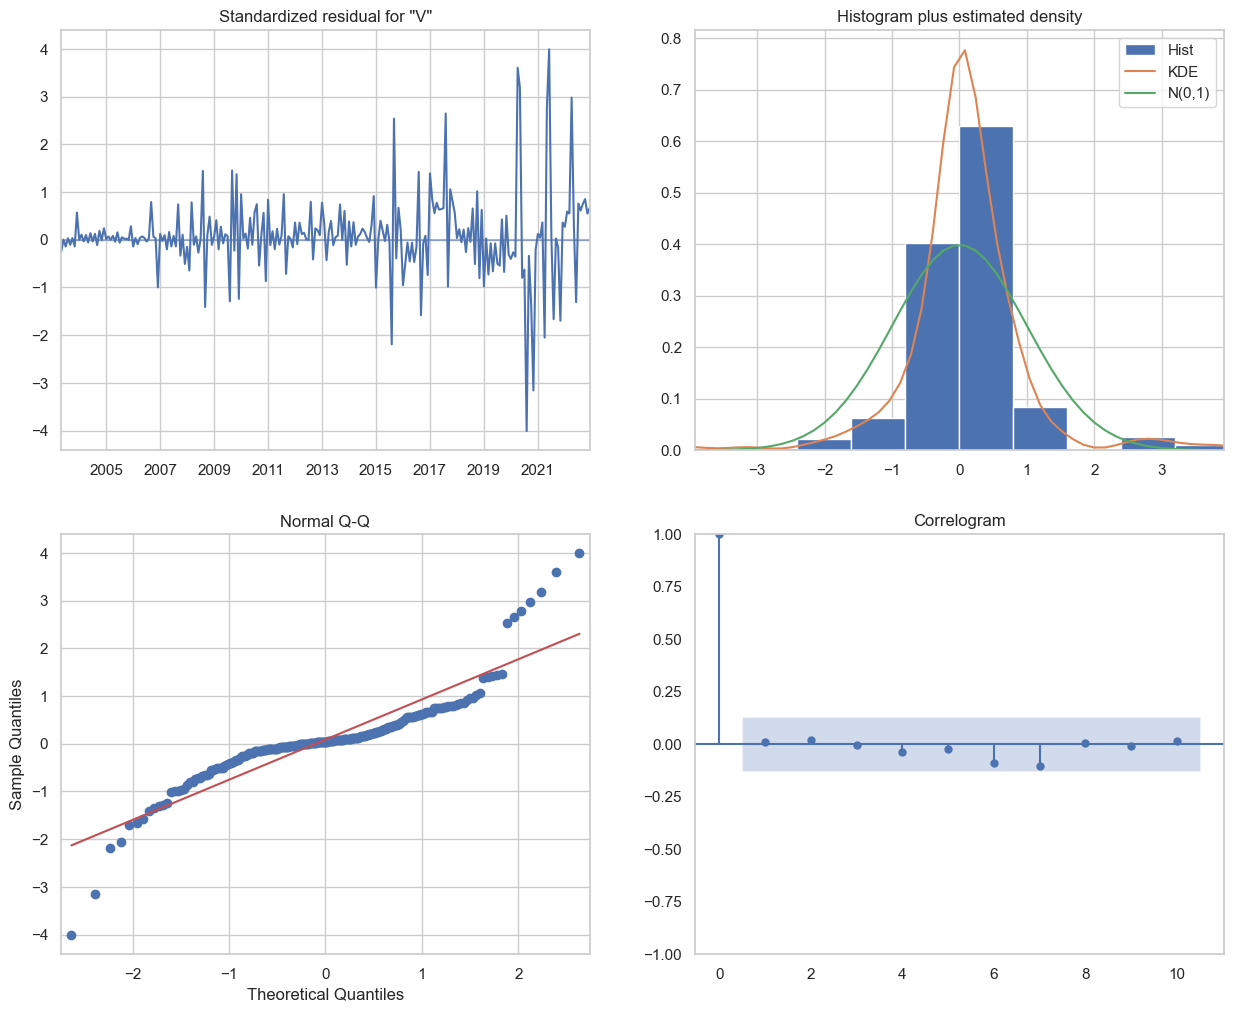

In [84]:
# Adjust the SARIMA model parameters to reduce the number of lags
# Example: Reduce p, q, P, and Q values
adjusted_result_df = result_df[(result_df['p'] <= 3) & (result_df['q'] <= 3) & (result_df['P'] <= 2) & (result_df['Q'] <= 2)]

# Ensure there are enough observations for the selected parameters
if len(adjusted_result_df) > 0:
	# Use the first valid parameter set from the adjusted DataFrame
	best_params = adjusted_result_df.iloc[0]
	p, d, q = int(best_params['p']), int(best_params['d']), int(best_params['q'])
	P, D, Q = int(best_params['P']), int(best_params['D']), int(best_params['Q'])
	s = 12  # Seasonal period remains the same

	# Refit the SARIMA model with adjusted parameters
	adjusted_model = sm.tsa.statespace.SARIMAX(
		df_sarima['Valor'],
		order=(p, d, q),
		seasonal_order=(P, D, Q, s),
		enforce_stationarity=False,
		enforce_invertibility=False
	)
	adjusted_result = adjusted_model.fit()

	# Plot diagnostics for the adjusted model
	adjusted_result.plot_diagnostics(figsize=(15, 12))
	plt.grid(False)
	plt.show()
else:
	print("No valid parameter set found with reduced lags.")

In [85]:
df_sarima['fitted'] = resultado_modelo.fittedvalues

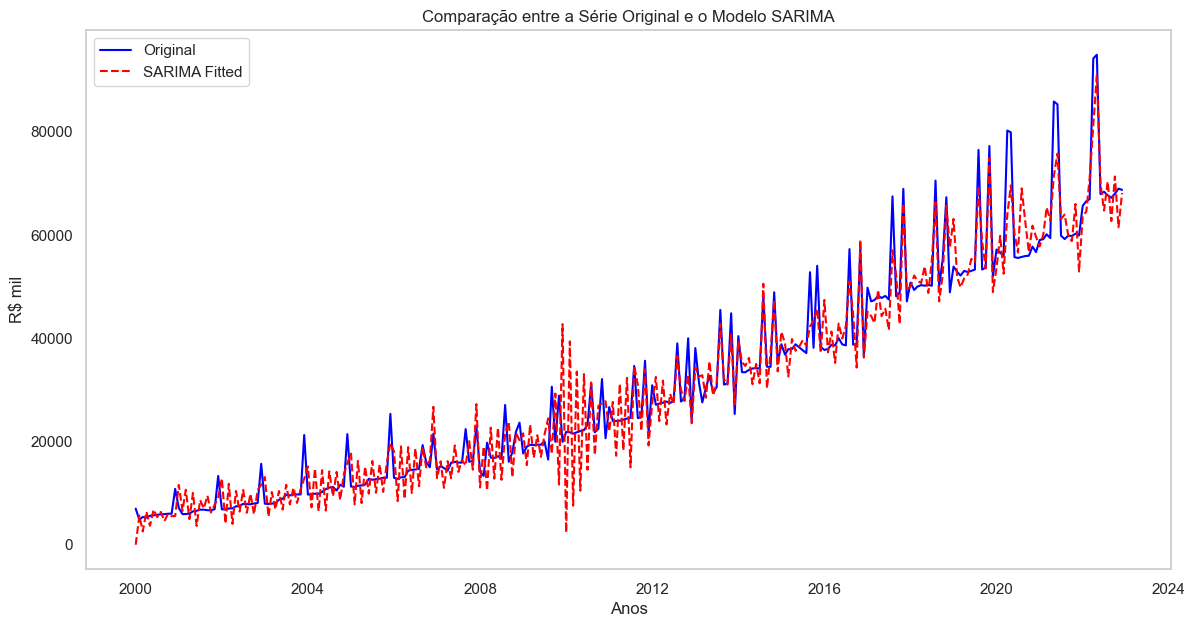

In [86]:
sns.set_theme(style="whitegrid")

# Plotando a série original e os valores ajustados pelo modelo
plt.figure(figsize=(14, 7))
plt.tight_layout()
sns.lineplot(data=df_sarima, x=df_sarima.index, y='Valor', label='Original', color='blue')
sns.lineplot(data=df_sarima, x=df_sarima.index, y='fitted', label='SARIMA Fitted', color='red', linestyle='--')
plt.title('Comparação entre a Série Original e o Modelo SARIMA')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.xlabel('Anos')
plt.ylabel('R$ mil')
plt.grid(False) 
plt.legend()
plt.show()

In [ ]:
# Criando a figura
fig = go.Figure()

# Adicionando a série original
fig.add_trace(go.Scatter(
    x=df_sarima.index,
    y=df_sarima['Valor'],
    mode='lines',
    name='Original',
    line=dict(color='blue')
))

# Adicionando os valores ajustados pelo modelo SARIMA
fig.add_trace(go.Scatter(
    x=df_sarima.index,
    y=df_sarima['fitted'],
    mode='lines',
    name='SARIMA Fitted',
    line=dict(color='red', dash='dash')
))

# Configurando o layout
fig.update_layout(
    title='Comparação entre a Série Original e o Modelo SARIMA',
    xaxis_title='Anos',
    yaxis_title='R$ mil',
    yaxis=dict(tickformat=',d'),  # Formata os valores inteiros no eixo Y
    template='plotly_white',
    hovermode='x',
)

# Exibir gráfico interativo
fig.show()

In [ ]:

pio.renderers.default = 'browser'  # Faz com que o gráfico abra no navegador
fig.show()

In [ ]:


# Configurando para exibir no VS Code e no navegador
pio.renderers.default = "vscode"  # Para exibição no VS Code
# pio.renderers.default = "browser"  # Se quiser apenas no navegador

# Calculando a diferença entre a série real e o modelo ajustado
df_sarima['erro'] = df_sarima['Valor'] - df_sarima['fitted']

# Criando a figura
fig = go.Figure()

# Adicionando a linha fixa no Y = 0
fig.add_trace(go.Scatter(
    x=df_sarima.index,
    y=[0] * len(df_sarima),  # Linha fixa no zero
    mode='lines',
    name='Linha Base (Y=0)',
    line=dict(color='black', dash='dash')
))

# Adicionando a série de erros (diferença entre real e ajustado)
fig.add_trace(go.Scatter(
    x=df_sarima.index,
    y=df_sarima['erro'],
    mode='lines',
    name='Erro (Real - Modelo)',
    line=dict(color='red')
))

# Configurando o layout
fig.update_layout(
    title='Erro entre a Série Real e o Modelo SARIMA',
    xaxis_title='Anos',
    yaxis_title='Erro (R$ mil)',
    template='plotly_white',
    hovermode='x',
)

# Exibir gráfico no VS Code
fig.show()

# Exibir gráfico no navegador
pio.renderers.default = "browser"
fig.show()

In [90]:
# Realizando o teste dos erros
teste = teste_erro(df_sarima['Valor'], df_sarima['fitted'])
teste

,Metric,Value
0,MAD,3.899529e+03
1,MAPE,1.882836e-01
2,MSD,2.683884e+07
3,MPE,-8.550580e-01


In [91]:
# Teste para anos antes de 2020
teste_antes = teste_erro(df_sarima.loc[df_sarima.index < '2020-01-01', 'Valor'], df_sarima.loc[df_sarima.index < '2020-01-01', 'fitted'])
teste_antes

,Metric,Value
0,MAD,3.752557e+03
1,MAPE,2.057562e-01
2,MSD,2.482643e+07
3,MPE,-1.043756e+00


In [92]:
from scipy.stats import shapiro
from statsmodels.stats.diagnostic import het_arch

residuos = resultado_modelo.resid

# Teste de Shapiro-Wilk
shapiro_test = shapiro(residuos)

# Teste de Heterocedasticidade ARCH
arch_test = het_arch(residuos)

# Resultados
test_results = {
    "Shapiro-Wilk": {"Statistic": shapiro_test.statistic, "p-value": shapiro_test.pvalue},
    "ARCH Test": {"LM Statistic": arch_test[0], "p-value": arch_test[1]}
}

test_results


{'Shapiro-Wilk': {'Statistic': np.float64(0.9666727413447939),
  'p-value': np.float64(5.16636706827974e-06)},
 'ARCH Test': {'LM Statistic': np.float64(128.44582600110616),
  'p-value': np.float64(9.690755259008697e-23)}}

/var/folders/wk/k6089y_d7hv_rwb2m8vbm9cr0000gn/T/ipykernel_6189/3000406950.py:4: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



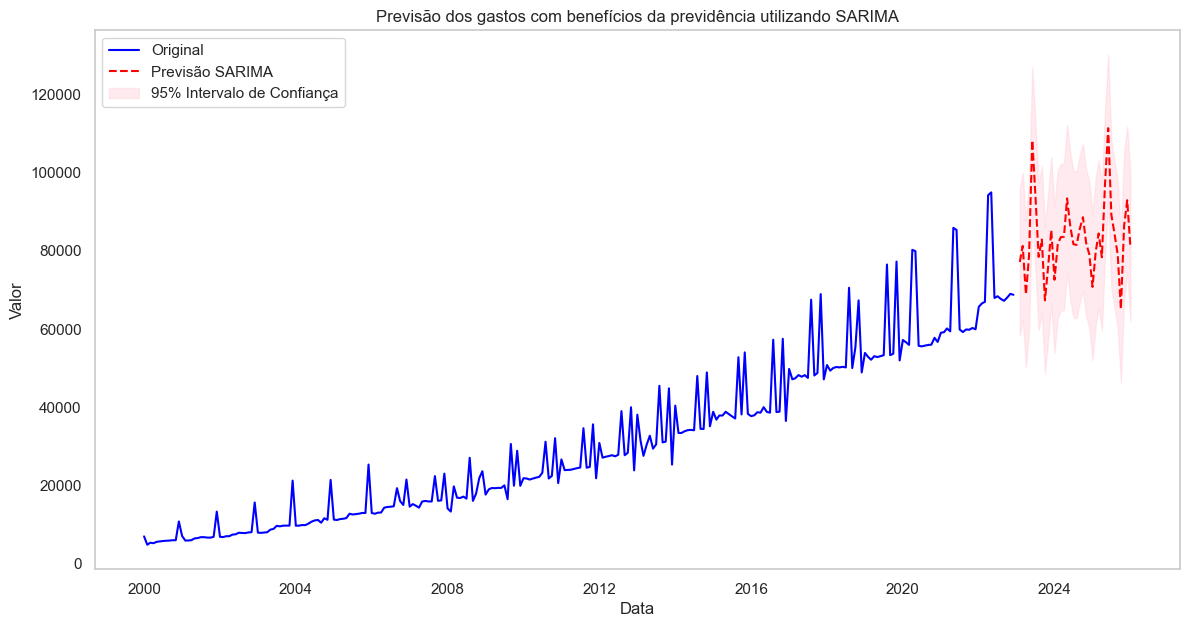

In [93]:
# Criando as previsões
forecast_periods = 36
forecast = resultado_modelo.forecast(steps=forecast_periods)
forecast_index = pd.date_range(start=df_sarima.index[-1], periods=forecast_periods+1, freq='M')[1:]
forecast_values = forecast.values

# Fazendo intervalo de confiança
ci = 1.96 * np.std(forecast_values)
lower_bound = forecast_values - ci
upper_bound = forecast_values + ci

# Fazendo os gráficos
plt.figure(figsize=(14, 7))
sns.lineplot(data=df_sarima, x=df_sarima.index, y='Valor', label='Original', color='blue')
sns.lineplot(x=forecast_index, y=forecast_values, label='Previsão SARIMA', color='red', linestyle='--')
plt.fill_between(forecast_index, lower_bound, upper_bound, color='pink', alpha=0.3, label='95% Intervalo de Confiança')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:.0f}'))
plt.title('Previsão dos gastos com benefícios da previdência utilizando SARIMA')
plt.grid(False)
plt.legend()
plt.show()

In [94]:
# Criando a figura interativa
fig = go.Figure()

# Configurar o Plotly para exibir no VS Code primeiro
pio.renderers.default = "vscode"

# Linha da série original
fig.add_trace(go.Scatter(
    x=df_sarima.index,
    y=df_sarima['Valor'],
    mode='lines',
    name='Original',
    line=dict(color='blue')
))

# Linha da previsão SARIMA
fig.add_trace(go.Scatter(
    x=forecast_index,
    y=forecast_values,
    mode='lines',
    name='Previsão SARIMA',
    line=dict(color='red', dash='dash')
))

# Área do intervalo de confiança
fig.add_trace(go.Scatter(
    x=list(forecast_index) + list(forecast_index[::-1]),
    y=list(upper_bound) + list(lower_bound[::-1]),
    fill='toself',
    fillcolor='rgba(255, 182, 193, 0.3)',  # Cor rosa com transparência
    line=dict(color='rgba(255,255,255,0)'),
    name='95% Intervalo de Confiança'
))

# Configurações do layout
fig.update_layout(
    title='Previsão dos gastos com benefícios da previdência utilizando SARIMA',
    xaxis_title='Anos',
    yaxis_title='R$ mil',
    template='plotly_white',
    hovermode='x',
)

# Exibir gráfico no VS Code
fig.show()


In [95]:
# Exibir gráfico no navegador
pio.renderers.default = "browser"
fig.show()